# Import Libraries

In [255]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# imbalanced data libraries
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc, f1_score, make_scorer
import shap

# feature engineering
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [273]:
# linear models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, ElasticNet, SGDClassifier

# tree-based models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

# resemble models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# other models
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [69]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Data Preparation

## missing data

In [ ]:
df_train.isnull().sum().sum() #0
df_test.isnull().sum().sum() #0
# no missing values

0

## data type

In [12]:
df_train.dtypes.value_counts()
df_test.dtypes.value_counts()
# all columns are numerical

float64    93
int64       3
Name: count, dtype: int64

## data exploration

Class 0: 5285
Class 1: 170
Proportion: 31.09 : 1


<Axes: title={'center': 'Count (target)'}, xlabel='Bankrupt?'>

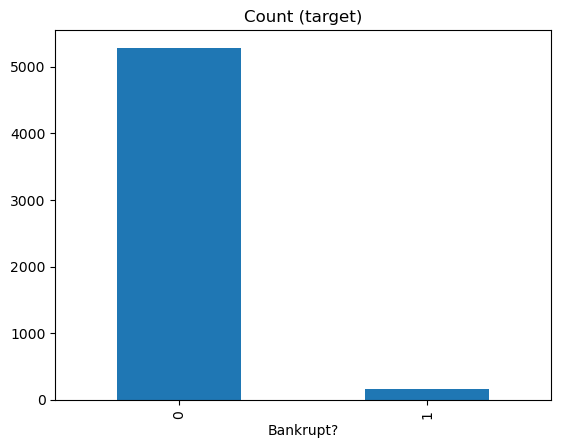

In [ ]:
target_count = df_train['Bankrupt?'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')
# (from resampling-strategies-for-imbalanced-datasets.ipynb)

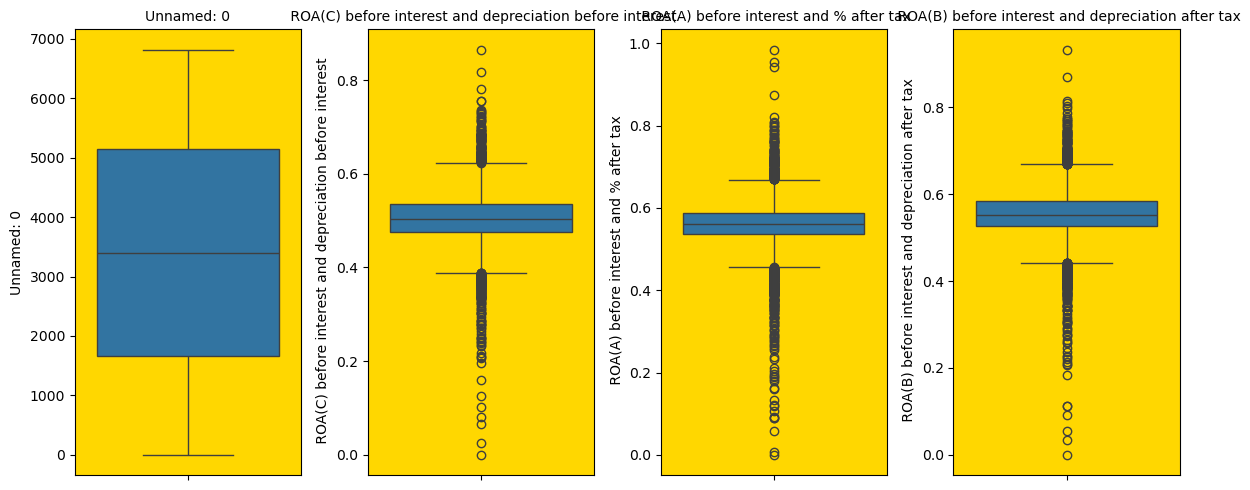

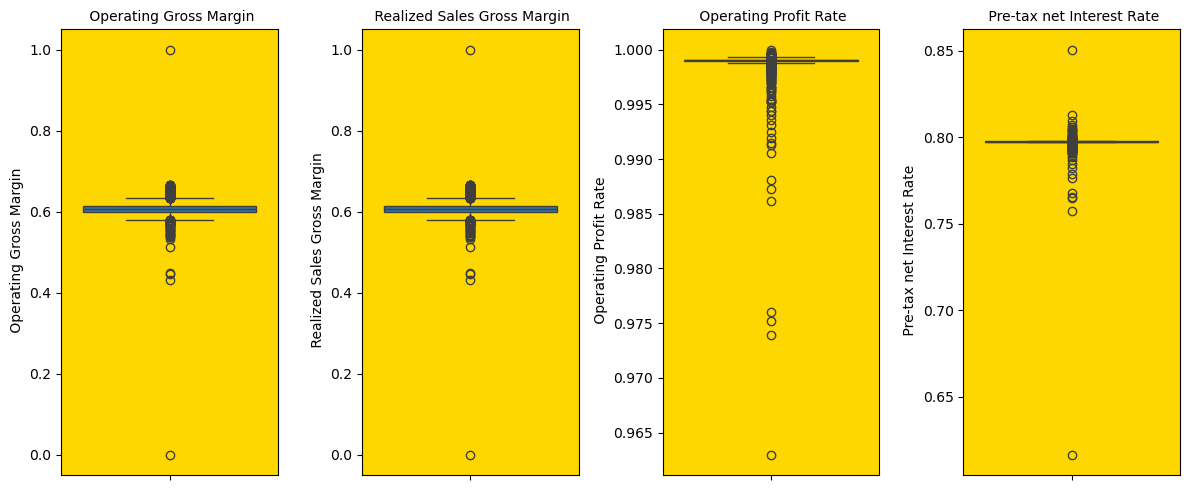

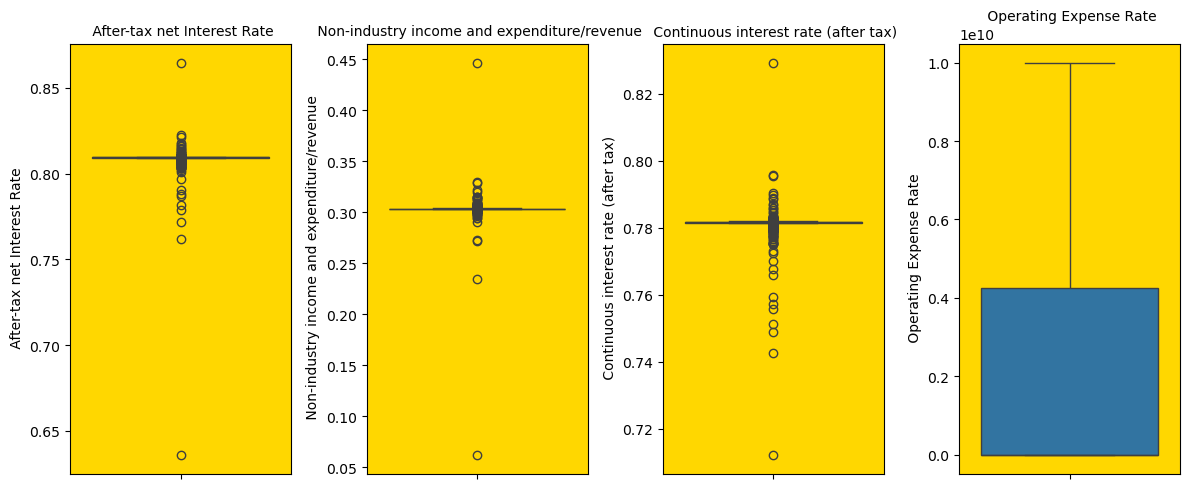

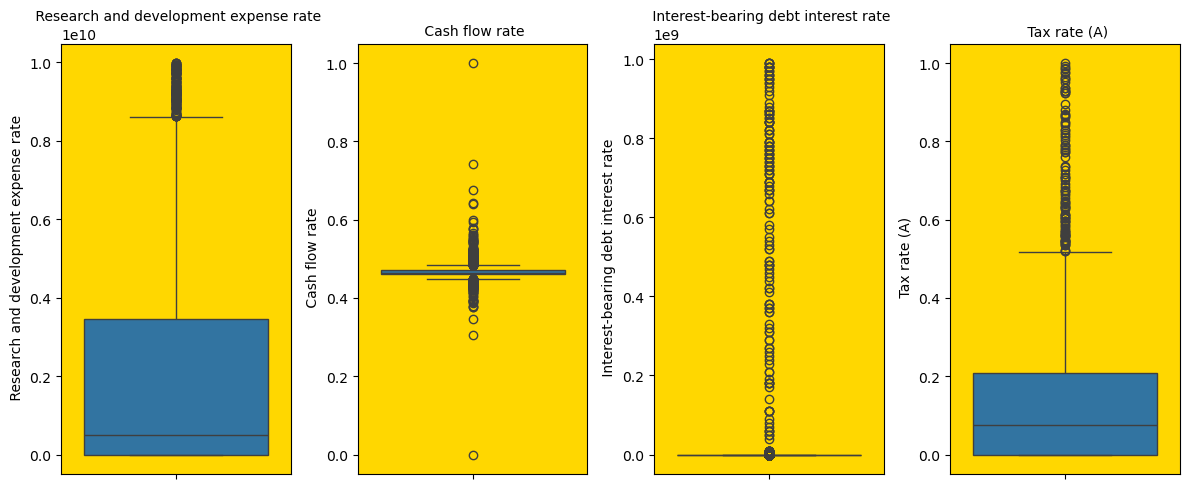

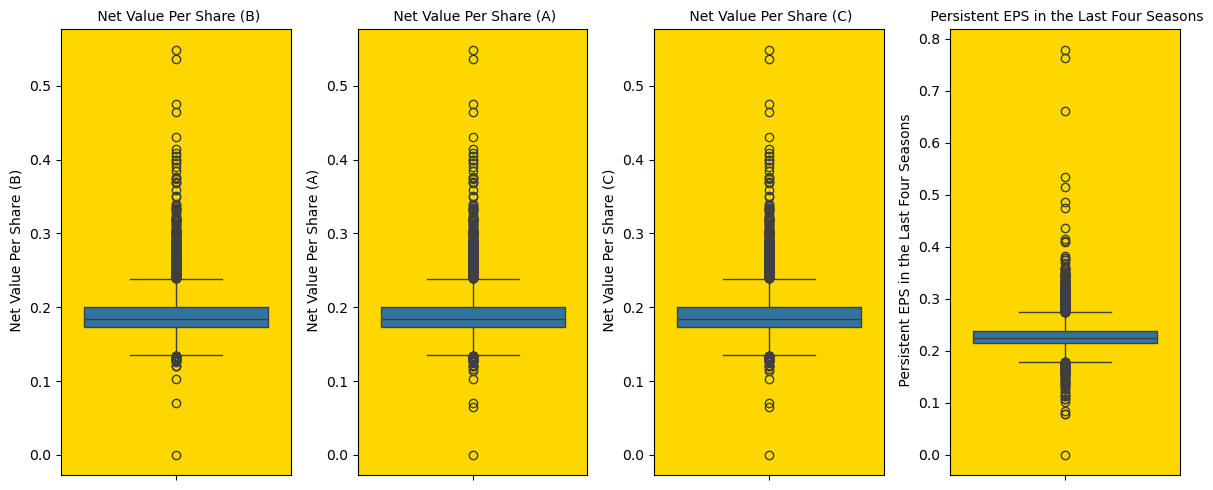

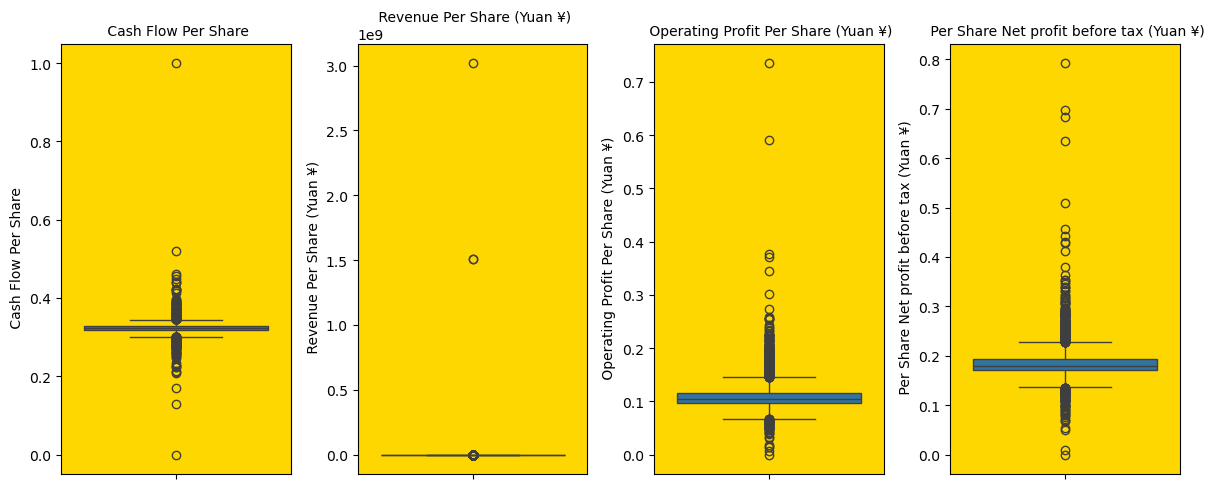

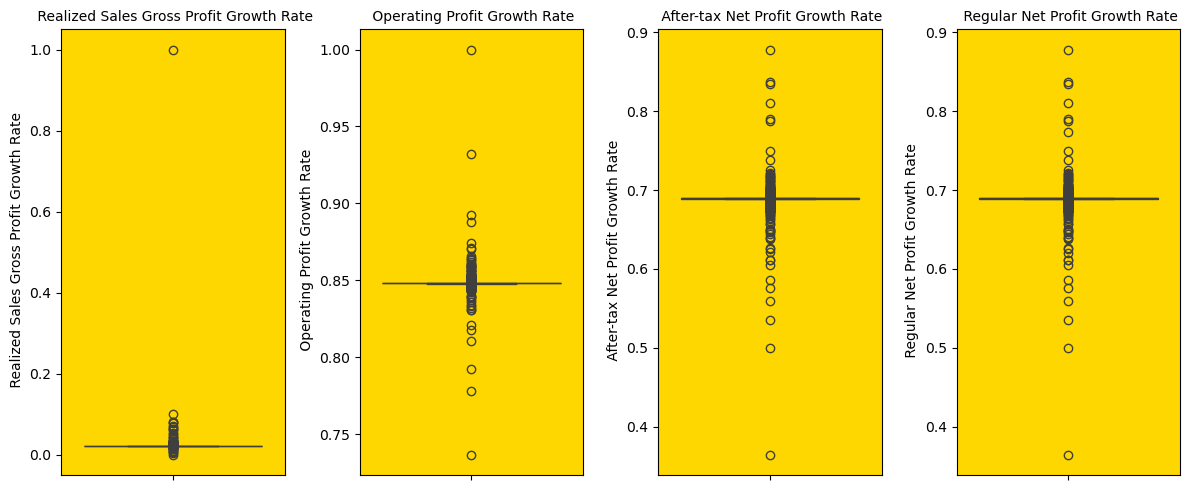

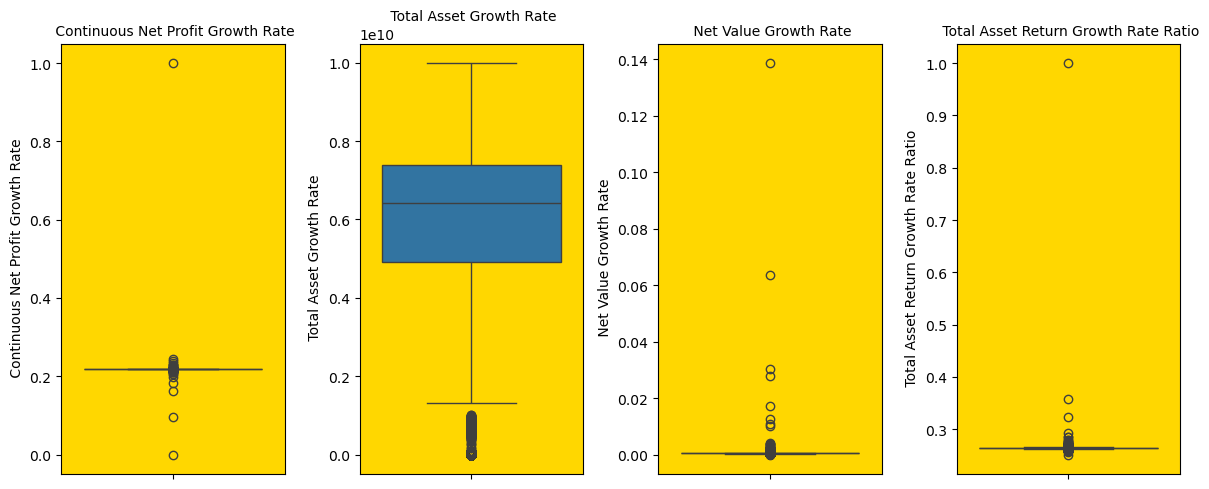

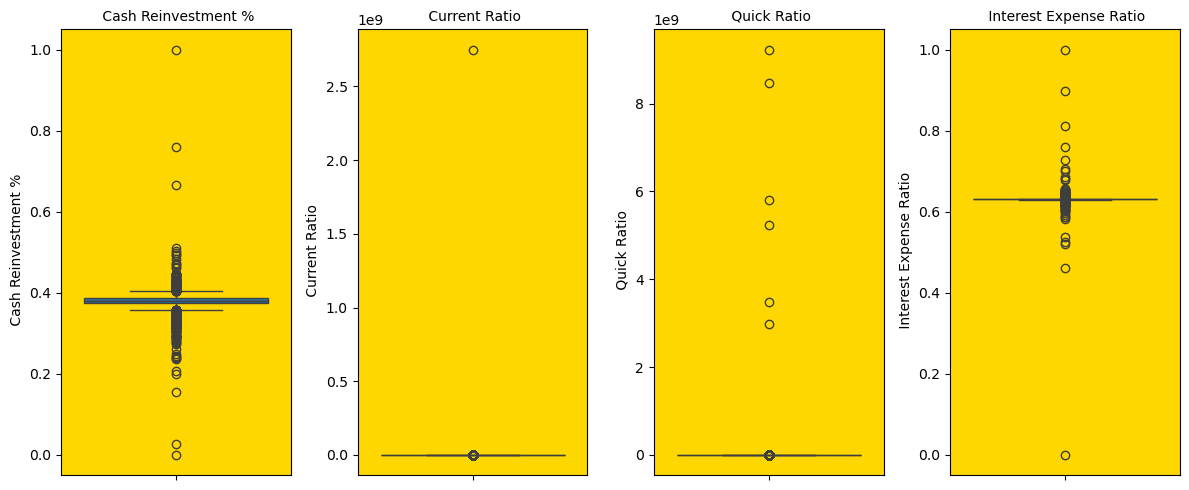

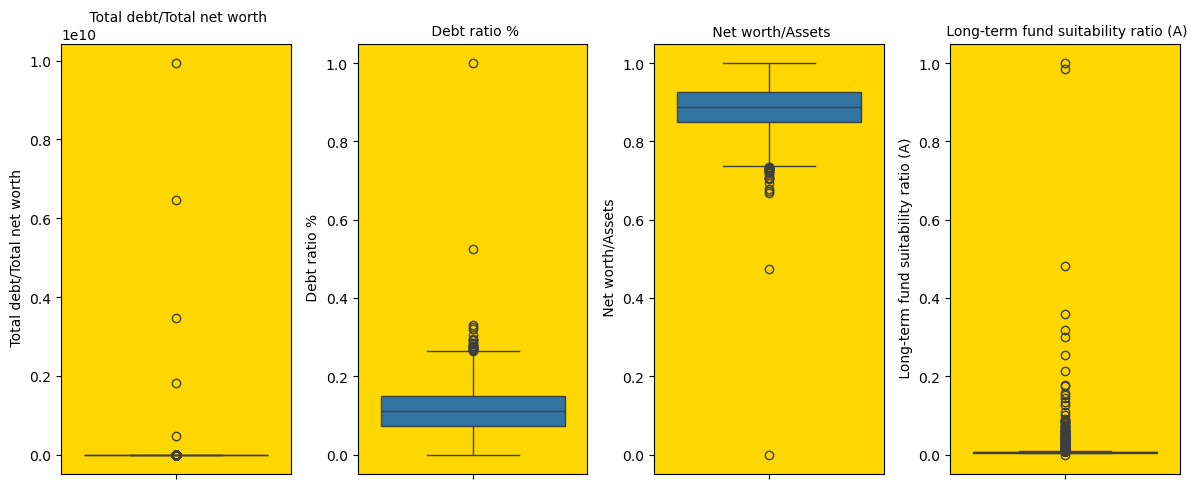

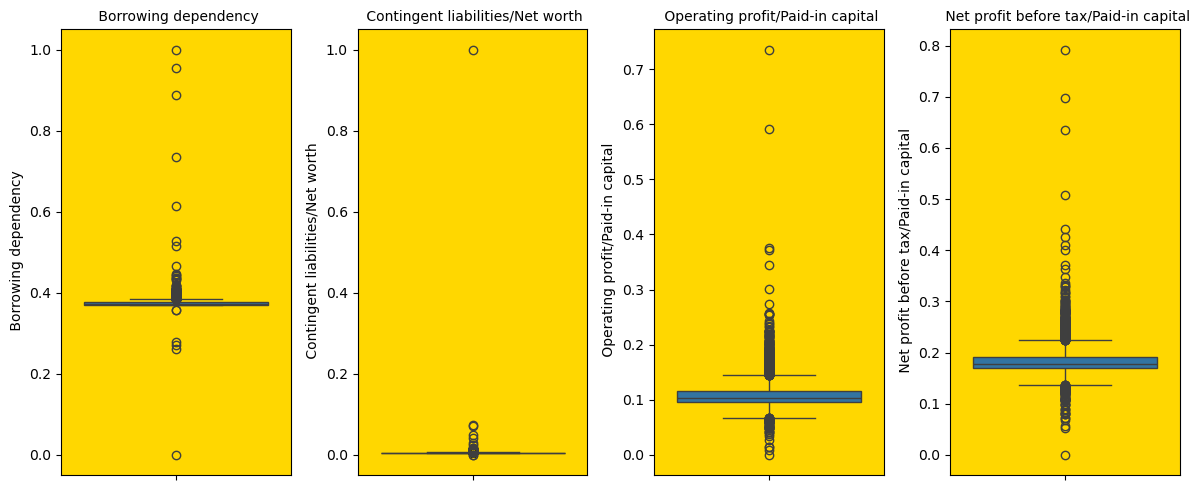

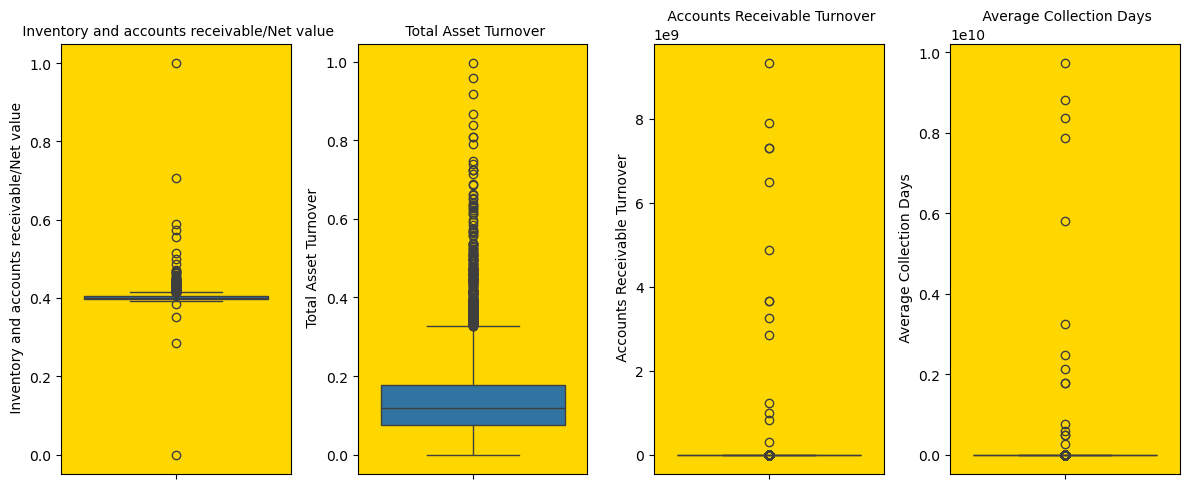

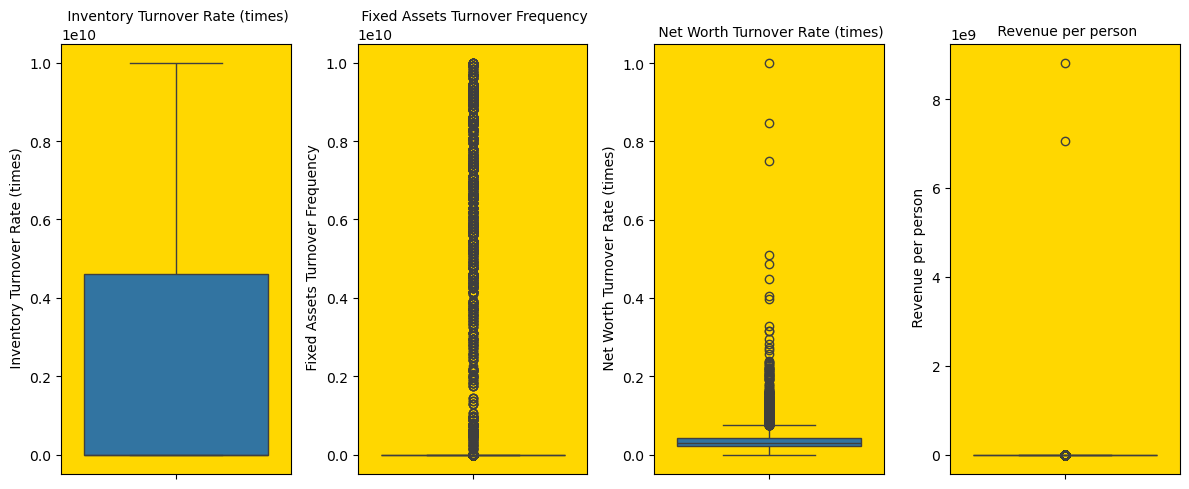

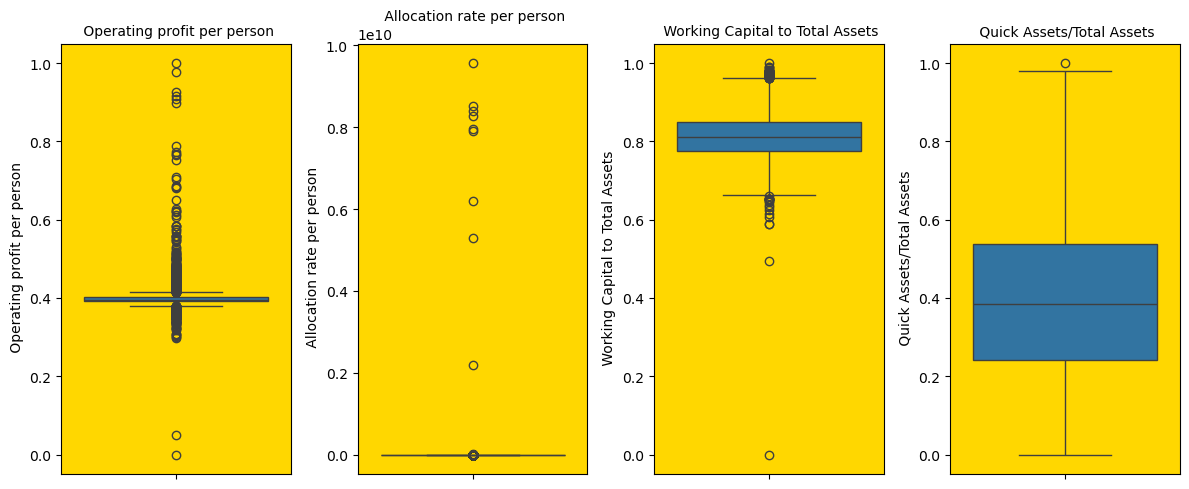

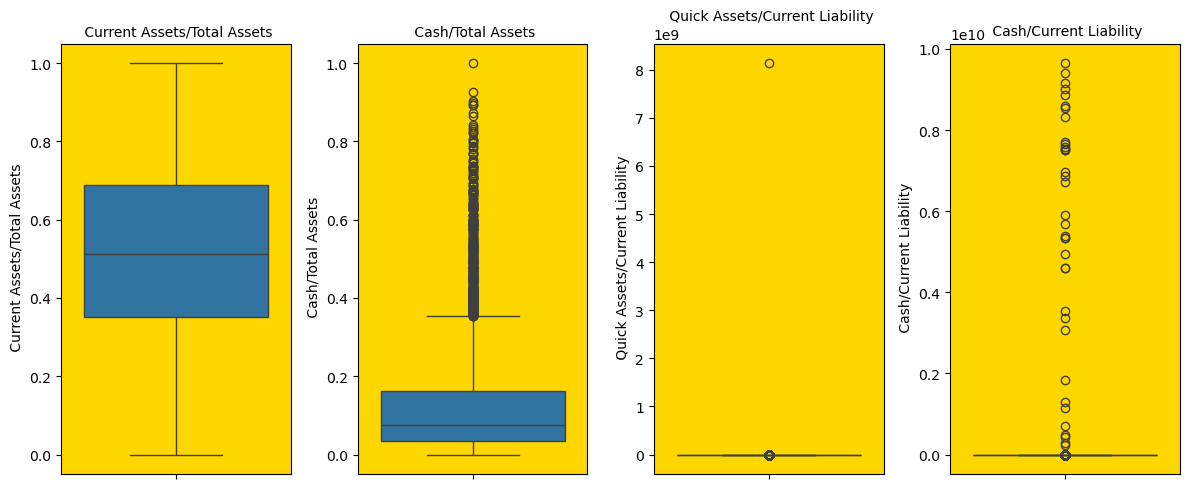

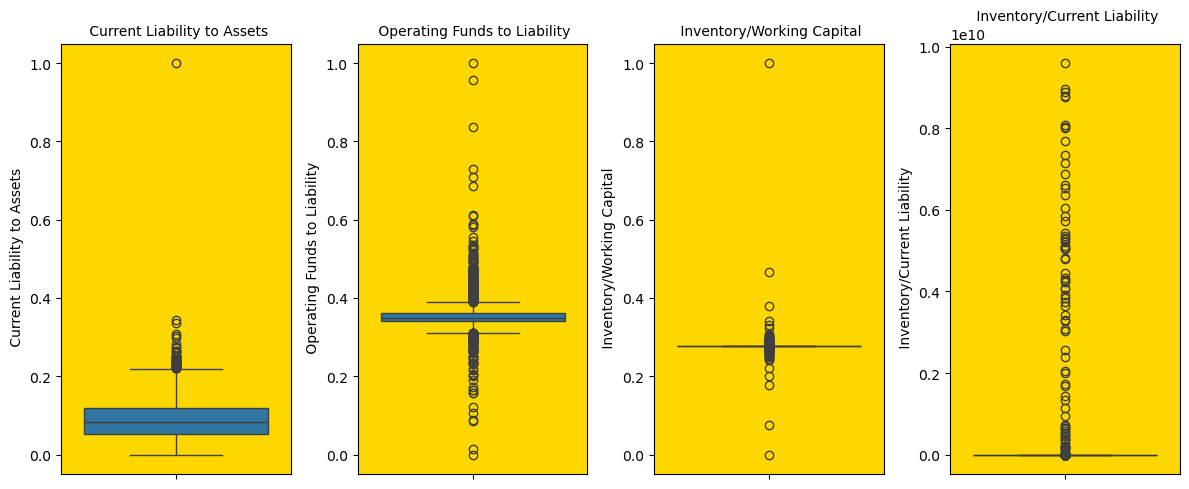

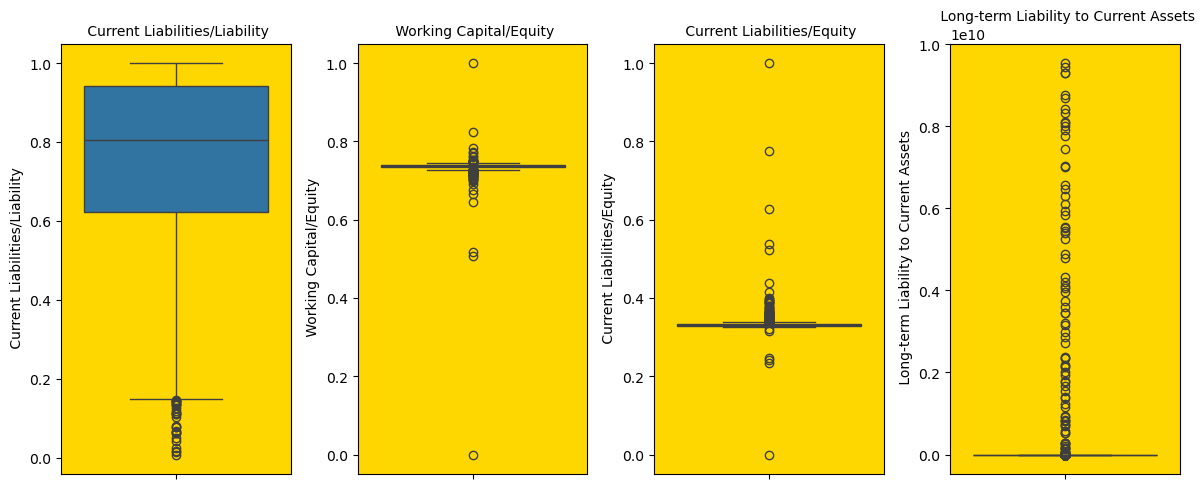

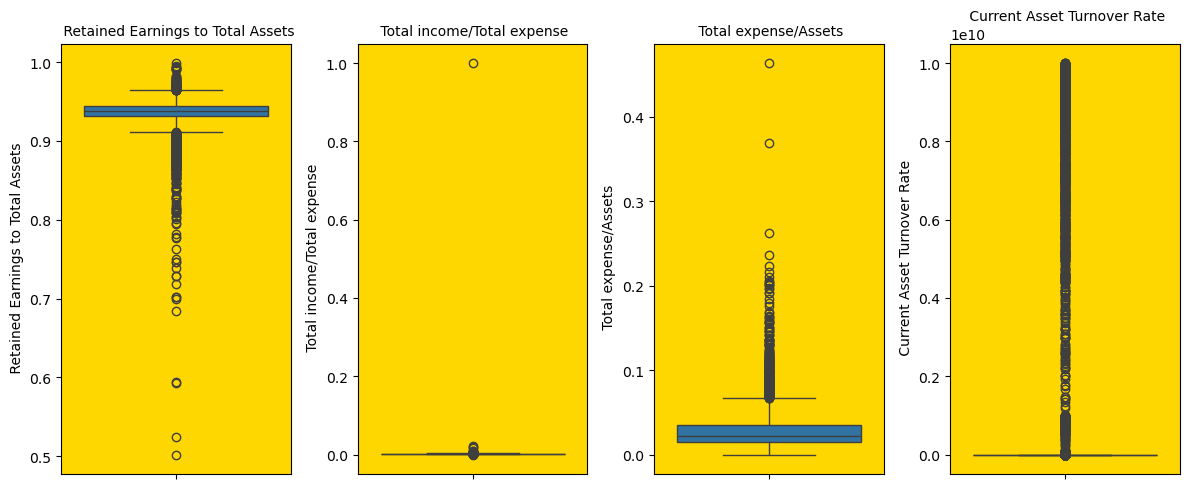

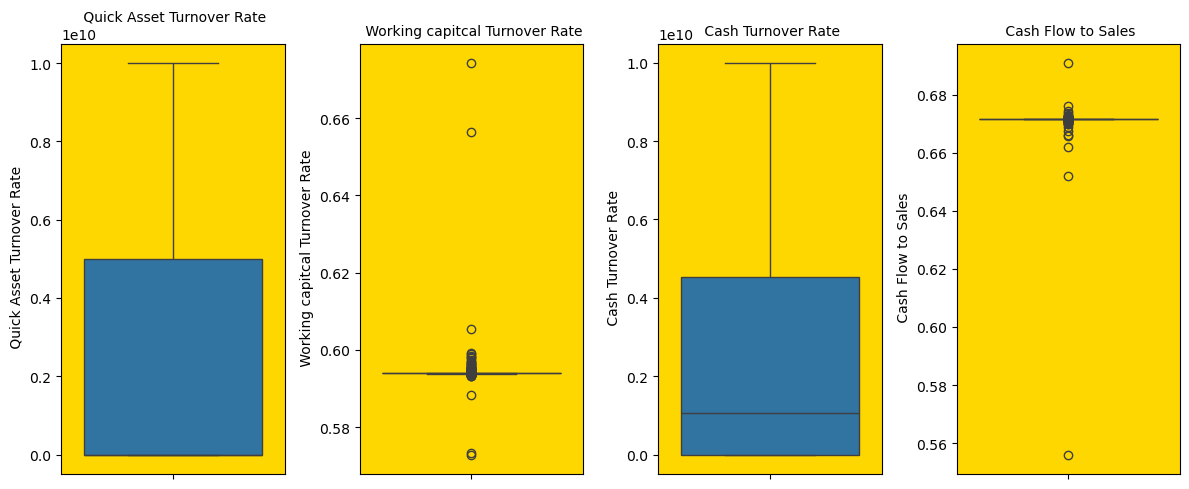

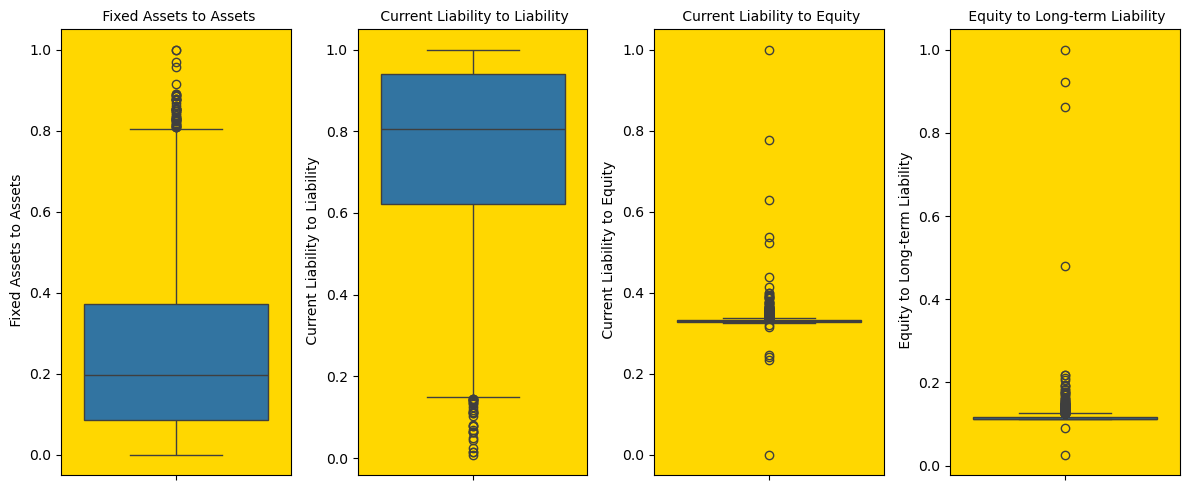

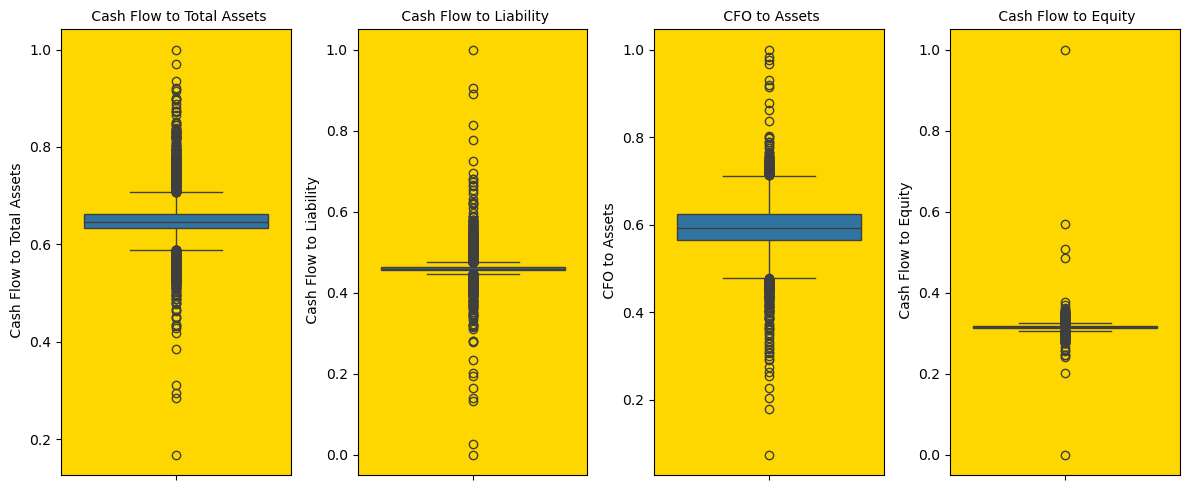

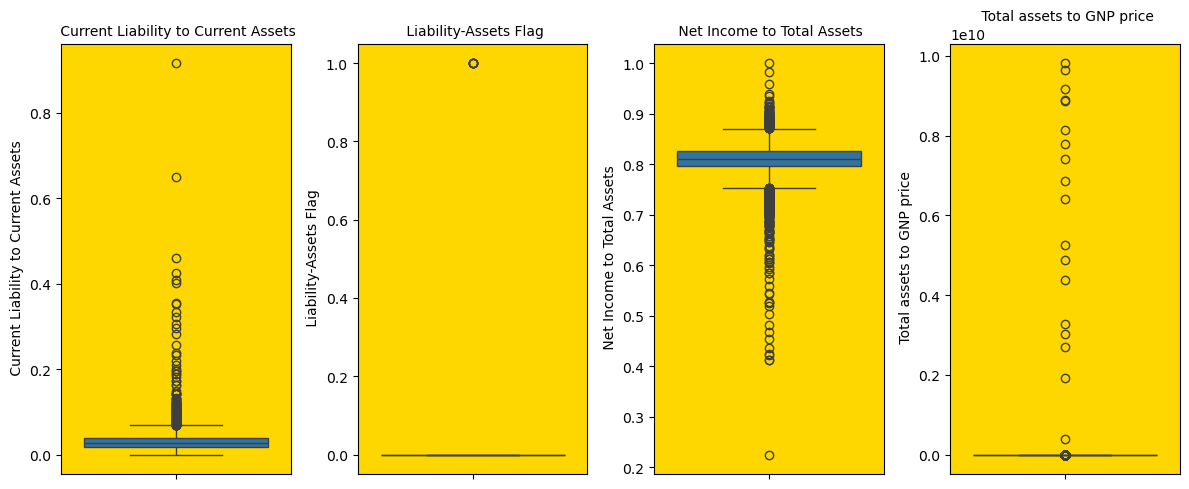

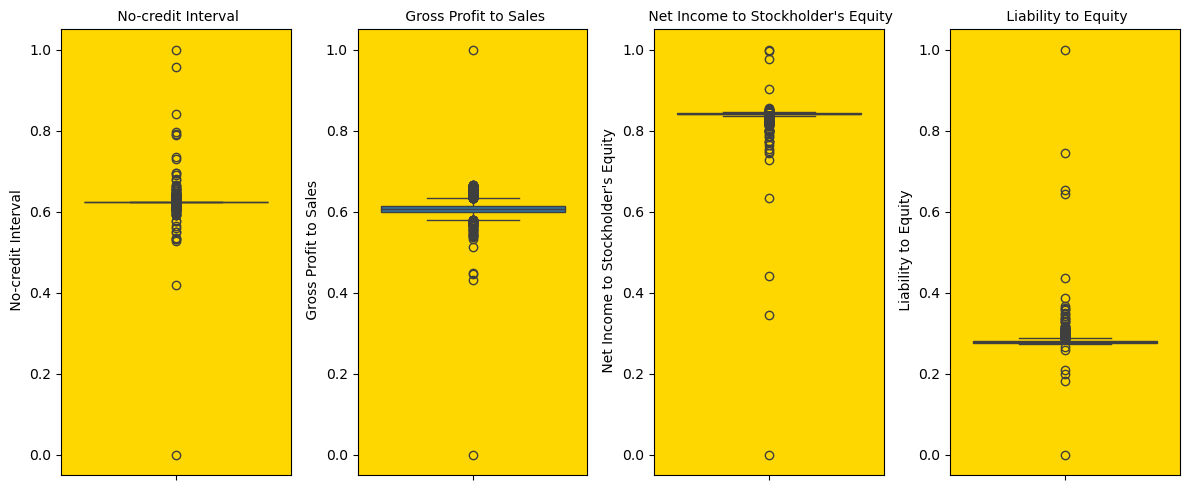

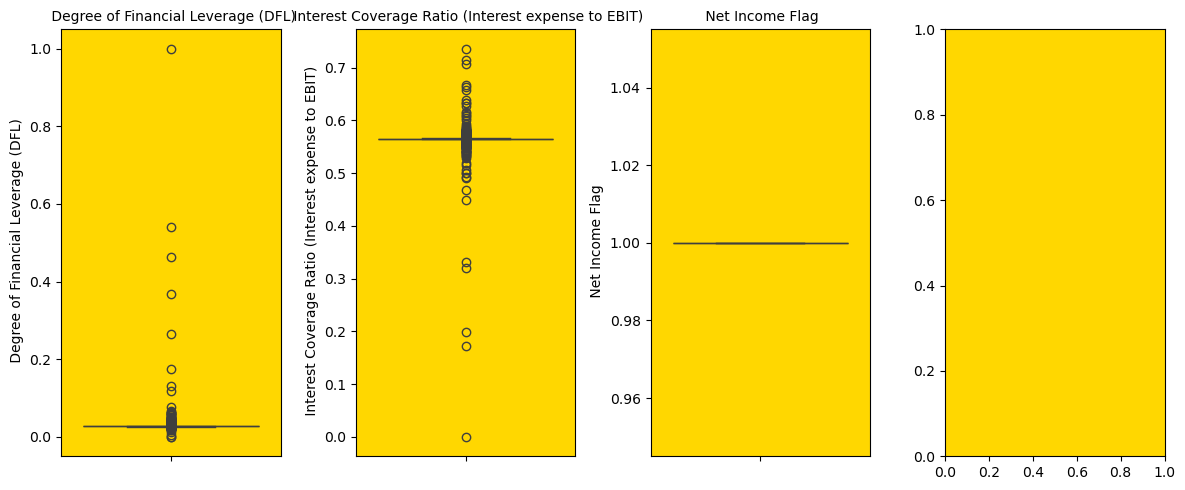

In [139]:
features = df_train.drop('Bankrupt?',axis=1).columns

for i in range(24):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(df_train[features[i*4]],ax=ax1)
    ax1.set_title(features[i*4],fontsize=10)
    ax1.set_facecolor('gold')
    ax2 = sns.boxplot(df_train[features[i*4+1]],ax=ax2)
    ax2.set_title(features[i*4+1],fontsize=10)
    ax2.set_facecolor('gold')
    ax3 = sns.boxplot(df_train[features[i*4+2]],ax=ax3)
    ax3.set_title(features[i*4+2],fontsize=10)
    ax3.set_facecolor('gold')
    if i < 23:
        ax4 = sns.boxplot(df_train[features[i*4+3]],ax=ax4)
        ax4.set_title(features[i*4+3],fontsize=10)
        ax4.set_facecolor('gold')
    else:    
        ax4.set_facecolor('gold')
    
    # fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    # fig.set_facecolor('darkgrey')

## data oversampling

In [ ]:
y = df_train['Bankrupt?']
X = df_train.drop(columns=['Bankrupt?'])

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [284]:
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)), 
    ('clf', XGBClassifier(n_estimators=100, random_state=42)) 
]) # (from chatgpt)

f1_over = cross_val_score(pipeline, X, y, cv=skf, scoring=make_scorer(f1_score))
f1 = cross_val_score(XGBClassifier(n_estimators=100, random_state=42),X,y,cv=skf,scoring='f1')


print(f"Cross-Validated F1 Score: ",f1, f1.mean())
print(f"Cross-Validated F1 Score (oversampling): ",f1_over, f1_over.mean())

Cross-Validated F1 Score:  [0.42553191 0.43137255 0.3255814  0.34482759 0.24      ] 0.35346268909379175
Cross-Validated F1 Score (oversampling):  [0.5625     0.475      0.44117647 0.39534884 0.50704225] 0.4762135122637329


## outlier

In [ ]:
df_train_float = df_train.select_dtypes(include='float')
df_quantile = df_train_float.quantile([0.25, 0.75]).T
df_quantile['IQR'] = df_quantile[0.75] - df_quantile[0.25]
df_quantile['high'] = df_quantile[0.75] + 1.5 * df_quantile['IQR']
df_quantile['low'] = df_quantile[0.25] - 1.5 * df_quantile['IQR']

In [ ]:
df_train_float.clip(lower=df_quantile['low'], upper=df_quantile['high'], axis=1, inplace=True)
df_train1 = df_train_float.join(df_train.select_dtypes(include='int'))
df_test_float = df_test.select_dtypes(include='float')
df_test_float.clip(lower=df_quantile['low'], upper=df_quantile['high'], axis=1, inplace=True)
df_test1 = df_test_float.join(df_test.select_dtypes(include='int'))

### impact on model result

In [ ]:
y1 = df_train1['Bankrupt?']
X1 = df_train1.drop(columns=['Bankrupt?'])

In [ ]:
f1_over_outlier = cross_val_score(pipeline, X1, y1, cv=skf, scoring=make_scorer(f1_score))
print(f"Cross-Validated F1 Score (oversampling , outlier): ",f1_over_outlier, f1_over_outlier.mean())
# [0.4137931  0.34920635 0.43478261 0.20833333 0.38709677] 0.3586424337754318

Cross-Validated F1 Score (outlier):  [0.34146341 0.4        0.35714286 0.13953488 0.44897959] 0.3374241494669337
Cross-Validated F1 Score (oversampling , outlier):  [0.4137931  0.34920635 0.43478261 0.20833333 0.38709677] 0.3586424337754318


# Feature Engineering

## feature importance

In [90]:
y = df_train['Bankrupt?']
X = df_train.drop(columns=['Bankrupt?'])

In [91]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
model.fit(X_train, y_train)
# feature importance
df_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
df_importance.sort_values('importance', ascending=False, inplace=True)

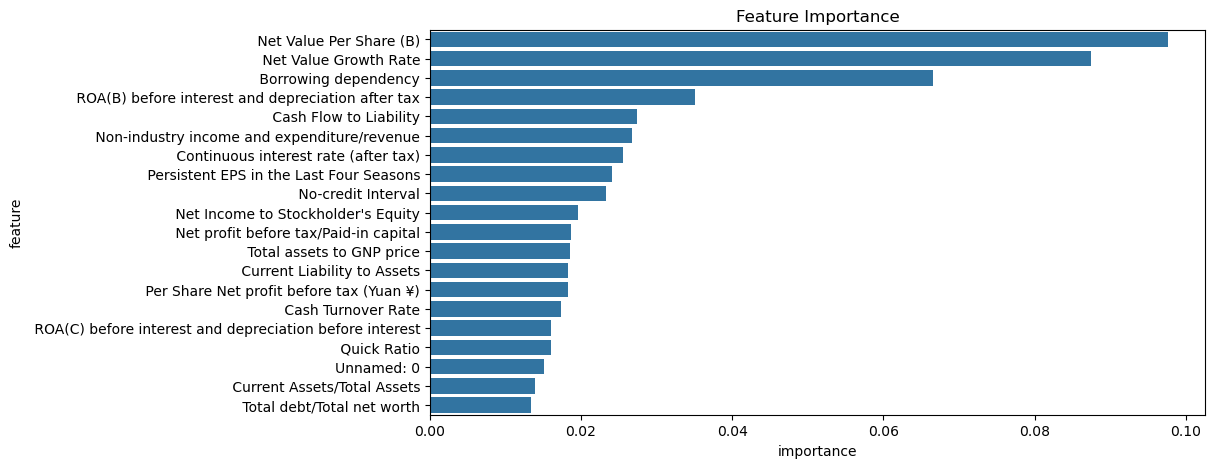

In [92]:
#plot feature importance (top 20)
plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=df_importance.head(20))
plt.title('Feature Importance')
plt.show()

In [93]:
df_train2 = df_train[list(df_importance.query('importance > 0.005')['feature'])+['Bankrupt?']] 
df_test2 = df_test[list(df_importance.query('importance > 0.005')['feature'])] 
# df_train3 = df_train[list(df_importance.query('importance > 0.01')['feature'])+['Bankrupt?']] 

### impact on model result

In [96]:
y2 = df_train2['Bankrupt?']
X2 = df_train2.drop(columns=['Bankrupt?'])
y3 = df_train3['Bankrupt?']
X3 = df_train3.drop(columns=['Bankrupt?'])

In [293]:
f1_over_feature1 = cross_val_score(pipeline, X2, y2, cv=skf, scoring='f1')
f1_feature1 = cross_val_score(XGBClassifier(n_estimators=100, random_state=42),X2,y2,cv=kf,scoring='f1')
print(f"Cross-Validated F1 Score (feature 1): ",f1_feature1, f1_feature1.mean())
print(f"Cross-Validated F1 Score (oversampling, feature 1): ",f1_over_feature1, f1_over_feature1.mean())

Cross-Validated F1 Score (feature 1):  [0.46153846 0.44827586 0.31034483 0.18604651 0.38297872] 0.3578368772451593
Cross-Validated F1 Score (oversampling, feature 1):  [0.49230769 0.53846154 0.38235294 0.4        0.51351351] 0.4653271370918429


In [ ]:
# # feature importance > 0.01
f1_over_feature2 = cross_val_score(pipeline, X3, y3, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 2): ",f1_over_feature2, f1_over_feature2.mean())
# # [0.45333333 0.47058824 0.34146341 0.43956044 0.43181818] 0.4273527209280437

## drop useless features

In [103]:
pipeline_feature = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X4 = pipeline_feature.fit_transform(X2)

In [292]:
f1_over_feature_drop = cross_val_score(pipeline, X4, y2, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 1 dropped): ",f1_over_feature_drop, f1_over_feature_drop.mean())

Cross-Validated F1 Score (oversampling, feature 1 dropped):  [0.5625     0.475      0.44117647 0.39534884 0.50704225] 0.4762135122637329


In [112]:
df_train4 = pd.concat([X4, y2], axis=1)
df_test4 = df_test2[X4.columns].copy()

## feature generation

### XXX per XXX(+ - * /)

In [205]:
df_train4.columns

Index([' Net Value Per Share (B)', ' Net Value Growth Rate',
       ' Borrowing dependency', ' Cash Flow to Liability',
       ' Continuous interest rate (after tax)', ' No-credit Interval',
       ' Net profit before tax/Paid-in capital', ' Total assets to GNP price',
       ' Current Liability to Assets', ' Cash Turnover Rate', ' Quick Ratio',
       'Unnamed: 0', ' Current Assets/Total Assets',
       ' Total debt/Total net worth', ' Total income/Total expense',
       ' Interest Expense Ratio', ' Operating profit per person',
       ' Current Liabilities/Liability', ' Contingent liabilities/Net worth',
       ' Inventory/Working Capital',
       ' Inventory and accounts receivable/Net value',
       ' Accounts Receivable Turnover', ' After-tax Net Profit Growth Rate',
       ' Working Capital to Total Assets', ' Revenue Per Share (Yuan ¥)',
       ' Operating Gross Margin',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Retained Earnings to Total Assets', ' 

In [ ]:
group1 = [' Net Value Per Share (B)', ' Operating profit per person', ' Revenue Per Share (Yuan ¥)', 
        ' Cash Flow Per Share',' Revenue per person']

In [199]:
def basic_generator(df,column1,column2):
    df["+" + column1 + "&" + column2] = df[column1] + df[column2]
    df["-" + column1 + "&" + column2] = df[column1] - df[column2]
    df["*" + column1 + "&" + column2] = df[column1] * df[column2]
    df["/" + column1 + "&" + column2] = df[column1] / df[column2]
    return df

In [ ]:
df_train6 = df_train4.copy()
for i in range(len(group1)):
    for j in range(i):
        df_train6 = basic_generator(df_train6,group1[i],group1[j])

df_train6.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train6.dropna(axis=1, inplace=True)

#### feature selection

In [202]:
y6 = df_train6['Bankrupt?']
X6 = df_train6.drop('Bankrupt?', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X6, y6, test_size=0.3, random_state=42, stratify=y)
model.fit(X_train, y_train)
# feature importance
df_importance = pd.DataFrame({'feature': X6.columns, 'importance': model.feature_importances_})
df_importance.sort_values('importance', ascending=False, inplace=True)

In [203]:
df_train6_1 = df_train6[list(df_importance.query('importance > 0.005')['feature'])+['Bankrupt?']] 
df_train6_2 = df_train6[list(df_importance.query('importance > 0.001')['feature'])+['Bankrupt?']]
# df_test2 = df_test[list(df_importance.query('importance > 0.005')['feature'])] 

X6_1 = df_train6_1.drop('Bankrupt?', axis=1)
X6_2 = df_train6_2.drop('Bankrupt?', axis=1)

In [204]:
f1_all_gen1 = cross_val_score(pipeline, X6_1, y6, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 1): ",f1_all_gen1, f1_all_gen1.mean())

f1_all_gen2 = cross_val_score(pipeline, X6_2, y6, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 2): ",f1_all_gen2, f1_all_gen2.mean())

Cross-Validated F1 Score (oversampling, feature 1):  [0.55384615 0.51219512 0.42105263 0.44705882 0.51282051] 0.4893946487452491
Cross-Validated F1 Score (oversampling, feature 2):  [0.57142857 0.52054795 0.3880597  0.39506173 0.45      ] 0.46501958930432996


In [207]:
df_train7 = df_train6_1.copy()
df_test7 = df_test4.copy()
for i in range(len(group1)):
    for j in range(i):
        df_test7 = basic_generator(df_test7,group1[i],group1[j])
df_test7 = df_test7[list(df_importance.query('importance > 0.005')['feature'])]

### XXX to XXX(+ - * /)

In [209]:
df_train7.columns

Index([' Net Value Per Share (B)', ' Net Value Growth Rate',
       ' Borrowing dependency', ' Continuous interest rate (after tax)',
       ' Cash Flow to Liability', ' Total income/Total expense',
       ' Total assets to GNP price', ' Current Assets/Total Assets',
       ' Quick Ratio', '+ Cash Flow Per Share& Revenue Per Share (Yuan ¥)',
       ' Cash Flow Per Share', '- Revenue per person& Net Value Per Share (B)',
       'Unnamed: 0',
       '- Revenue Per Share (Yuan ¥)& Operating profit per person',
       ' Interest-bearing debt interest rate',
       '* Cash Flow Per Share& Net Value Per Share (B)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       '+ Operating profit per person& Net Value Per Share (B)',
       ' Total debt/Total net worth',
       '- Revenue per person& Operating profit per person',
       ' Accounts Receivable Turnover',
       '+ Cash Flow Per Share& Operating profit per person',
       ' Interest Expense Ratio', ' Net profit before tax

In [210]:
group2 = [' Cash Flow to Liability', ' Total income/Total expense',' Total assets to GNP price', ' Current Assets/Total Assets',
        ' Quick Ratio', ' Total debt/Total net worth', ' Interest Expense Ratio', ' Net profit before tax/Paid-in capital',
       ' Current Liability to Assets',' Inventory/Working Capital', ' Total expense/Assets',' Retained Earnings to Total Assets',
       ' Inventory and accounts receivable/Net value', ' Cash/Total Assets',' Contingent liabilities/Net worth',' Quick Assets/Total Assets']

In [211]:
df_train8 = df_train7.copy()
for i in range(len(group2)):
    for j in range(i):
        df_train8 = basic_generator(df_train8,group2[i],group2[j])

df_train8.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train8.dropna(axis=1, inplace=True)

#### feature selection

In [215]:
y8 = df_train8['Bankrupt?']
X8 = df_train8.drop('Bankrupt?', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X8, y8, test_size=0.3, random_state=42, stratify=y)
model.fit(X_train, y_train)
# feature importance
df_importance = pd.DataFrame({'feature': X8.columns, 'importance': model.feature_importances_})
df_importance.sort_values('importance', ascending=False, inplace=True)

In [ ]:
df_train8_1 = df_train8[list(df_importance.query('importance > 0.01')['feature'])+['Bankrupt?']] 
df_train8_2 = df_train8[list(df_importance.query('importance > 0.005')['feature'])+['Bankrupt?']] 
df_train8_3 = df_train8[list(df_importance.query('importance > 0.001')['feature'])+['Bankrupt?']]
# df_test2 = df_test[list(df_importance.query('importance > 0.005')['feature'])] 

X8_1 = df_train8_1.drop('Bankrupt?', axis=1)
X8_2 = df_train8_2.drop('Bankrupt?', axis=1)
X8_3 = df_train8_3.drop('Bankrupt?', axis=1)

In [217]:
f1_all_gen1 = cross_val_score(pipeline, X8_1, y8, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 1): ",f1_all_gen1, f1_all_gen1.mean())

f1_all_gen2 = cross_val_score(pipeline, X8_2, y8, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 2): ",f1_all_gen2, f1_all_gen2.mean())

f1_all_gen3 = cross_val_score(pipeline, X8_3, y8, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 3): ",f1_all_gen3, f1_all_gen3.mean())

Cross-Validated F1 Score (oversampling, feature 1):  [0.50574713 0.46       0.27083333 0.44897959 0.37037037] 0.41118608439544396
Cross-Validated F1 Score (oversampling, feature 2):  [0.49315068 0.53333333 0.475      0.43956044 0.5       ] 0.4882088915650559
Cross-Validated F1 Score (oversampling, feature 3):  [0.52307692 0.5        0.4057971  0.41975309 0.52941176] 0.4756077751303668


### growth rate(+ - * /)

In [219]:
group3 = [' Net Value Growth Rate',' Total Asset Growth Rate',' Continuous Net Profit Growth Rate',
        ' After-tax Net Profit Growth Rate',' Operating Profit Growth Rate']

In [220]:
df_train9 = df_train7.copy()
for i in range(len(group3)):
    for j in range(i):
        df_train9 = basic_generator(df_train9,group3[i],group3[j])

df_train9.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train9.dropna(axis=1, inplace=True)

#### feature selection

In [222]:
X9 = df_train9.drop('Bankrupt?', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X9, y, test_size=0.3, random_state=42, stratify=y)
model.fit(X_train, y_train)
# feature importance
df_importance = pd.DataFrame({'feature': X9.columns, 'importance': model.feature_importances_})
df_importance.sort_values('importance', ascending=False, inplace=True)

In [ ]:
X9_1 = df_train9[list(df_importance.query('importance > 0.01')['feature'])]
X9_2 = df_train9[list(df_importance.query('importance > 0.005')['feature'])]
X9_3 = df_train9[list(df_importance.query('importance > 0.001')['feature'])]
X9_4 = df_train9[list(df_importance.query('importance > 0.0005')['feature'])]

In [ ]:
f1_all_gen1 = cross_val_score(pipeline, X9_1, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 1): ",f1_all_gen1, f1_all_gen1.mean())

f1_all_gen2 = cross_val_score(pipeline, X9_2, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 2): ",f1_all_gen2, f1_all_gen2.mean())

f1_all_gen3 = cross_val_score(pipeline, X9_3, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 3): ",f1_all_gen3, f1_all_gen3.mean())

f1_all_gen4 = cross_val_score(pipeline, X9_4, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score (oversampling, feature 4): ",f1_all_gen4, f1_all_gen4.mean())

Cross-Validated F1 Score (oversampling, feature 1):  [0.54761905 0.41975309 0.3908046  0.39583333 0.38202247] 0.42720650739667915
Cross-Validated F1 Score (oversampling, feature 2):  [0.47222222 0.525      0.35       0.4        0.56      ] 0.46144444444444443
Cross-Validated F1 Score (oversampling, feature 3):  [0.5915493  0.54761905 0.44736842 0.41975309 0.53164557] 0.5075870840972666
Cross-Validated F1 Score (oversampling, feature 4):  [0.50847458 0.525      0.43037975 0.41463415 0.5       ] 0.4756976938896186


In [ ]:
df_train10 = pd.concat([X9_3, y], axis=1)
df_test10 = df_test7.copy()
for i in range(len(group3)):
    for j in range(i):
        df_test10 = basic_generator(df_test10,group3[i],group3[j])
df_test10 = df_test10[list(df_importance.query('importance > 0.001')['feature'])]


In [287]:
np.inf in df_test10

False

# Model Construction

## model selection

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "SGDClassifier": SGDClassifier(loss="log_loss", random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "BaggingClassifier": BaggingClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=100, random_state=42),
    "LGBMClassifier": LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoostClassifier": CatBoostClassifier(n_estimators=100, learning_rate=0.1, verbose=0, random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42),
    "SVC": SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
}

In [248]:
for name,model in models.items():
    pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)), 
    ('clf', model) 
    ])
    f1_score = cross_val_score(pipeline, X9_3.values, y, cv=skf, scoring='f1')
    print(f"Cross-Validated F1 Score for {name} : ",f1_score, f1_score.mean())  

Cross-Validated F1 Score for LogisticRegression :  [0.18181818 0.27428571 0.16981132 0.17977528 0.20430108] 0.20199831460526135
Cross-Validated F1 Score for RidgeClassifier :  [0.25454545 0.24701195 0.24324324 0.26666667 0.22330097] 0.24695365750407722
Cross-Validated F1 Score for ElasticNet :  [nan nan nan nan nan] nan
Cross-Validated F1 Score for SGDClassifier :  [0.06231156 0.06288032 0.02380952 0.05       0.06203008] 0.0522062962660098
Cross-Validated F1 Score for RandomForestClassifier :  [0.56716418 0.55813953 0.47619048 0.32941176 0.49350649] 0.4848824896782101
Cross-Validated F1 Score for GradientBoostingClassifier :  [0.47524752 0.47863248 0.375      0.35       0.42201835] 0.42017967040176146
Cross-Validated F1 Score for AdaBoostClassifier :  [0.35802469 0.32786885 0.30674847 0.28915663 0.32911392] 0.32218251212627336
Cross-Validated F1 Score for ExtraTreesClassifier :  [0.48275862 0.50632911 0.42857143 0.32       0.36842105] 0.42121604316334266
Cross-Validated F1 Score for Ba

In [253]:
# KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X9_3)
f1_score = cross_val_score(pipeline, X_train_scaled, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score for KNN : ",f1_score, f1_score.mean())  

Cross-Validated F1 Score for KNN :  [0.25       0.19512195 0.15       0.04878049 0.14634146] 0.15804878048780488


## parameter tuning

### random forest

In [262]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),  # 过采样步骤
    ('rf', RandomForestClassifier(random_state=42))  # 分类器
])

param_grid_rf = {
    'smote__sampling_strategy': [0.5, 1.0, 'auto'],  
    'rf__n_estimators': [50, 100, 200],  
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4] 
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=skf, scoring='f1')
grid_search_rf.fit(X9_3.values, y)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best F1 Score:", grid_search_rf.best_score_)

Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 50, 'smote__sampling_strategy': 0.5}
Best F1 Score: 0.4895089787055166


In [283]:
pd.DataFrame(grid_search_rf.cv_results_).to_csv('results/grid_search_rf_results.csv')

### Xgboost

In [259]:
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])

param_grid_xgb = {
    'smote__sampling_strategy': [0.5, 1.0, 'auto'],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 10],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=skf, scoring='f1')
grid_search_xgb.fit(X9_3.values, y)

print("Best Parameters:",grid_search_xgb.best_params_)
print("Best F1 Score:",grid_search_xgb.best_score_)

Best Parameters: {'smote__sampling_strategy': 0.5, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
Best F1 Score: 0.5048518872431916


In [282]:
pd.DataFrame(grid_search_xgb.cv_results_).to_csv('results/grid_search_xgb_results.csv')

### LightGBM

In [260]:
pipeline_lgbm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42,verbose=-1))
])

param_grid_lgbm = {
    'smote__sampling_strategy': [0.5, 1.0, 'auto'],
    'lgbm__n_estimators': [100, 200, 300],
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__learning_rate': [0.01, 0.05, 0.1]
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=skf, scoring='f1')
grid_search_lgbm.fit(X9_3.values, y)

print("Best Parameters:",grid_search_lgbm.best_params_)
print("Best F1 Score:",grid_search_lgbm.best_score_)

Best Parameters: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 300, 'smote__sampling_strategy': 1.0}
Best F1 Score: 0.5107879867046534


In [281]:
pd.DataFrame(grid_search_lgbm.cv_results_).to_csv('results/grid_search_lgbm_results.csv')

## model fusion

In [ ]:
model_rf = grid_search_rf.best_estimator_
model_xgb = grid_search_xgb.best_estimator_
model_lgbm = grid_search_lgbm.best_estimator_

### soft voting

In [271]:
voting_clf = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('lgbm', model_lgbm)
], voting='soft')

f1_soft = cross_val_score(voting_clf, X9_3.values, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score for Soft Voting Classifier : ",f1_soft, f1_soft.mean())  

Cross-Validated F1 Score for Soft Voting Classifier :  [0.58064516 0.55696203 0.5        0.41975309 0.53333333] 0.5181387212719729


### hard voting

In [277]:
voting_clf1 = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('lgbm', model_lgbm)
], voting='hard')

f1_hard = cross_val_score(voting_clf1, X9_3.values, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score for Hard Voting Classifier : ",f1_hard, f1_hard.mean())  

Cross-Validated F1 Score for Hard Voting Classifier :  [0.57142857 0.575      0.51351351 0.41463415 0.53333333] 0.5215819129233763


### stacking

In [275]:
base_models = [
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('lgbm', model_lgbm)
]
meta_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=False)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=skf)

f1_stacking = cross_val_score(stacking_clf, X9_3.values, y, cv=skf, scoring='f1')
print(f"Cross-Validated F1 Score for Stacking : ",f1_stacking, f1_stacking.mean())  

Cross-Validated F1 Score for Stacking :  [0.28       0.42105263 0.38461538 0.4057971  0.44827586] 0.38794819594251456


# Prediction

In [ ]:
X_test = df_test10
X_test = np.clip(X_test, -1e6, 1e6)  
voting_clf1.fit(X9_3.values, y)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
# prediction
pd.DataFrame(voting_clf1.predict(X_test), columns=['Bankrupt?']).to_csv('results/prediction.csv', index=False)